# Codificação densa

__Limite de Holevo__: Não é possível extrair mais que $n$ cbits de $n$ qubits.

## Protocolo
Para $|\Phi_+\rangle = (|00\rangle+|11\rangle)/\sqrt{2}$ temos
\begin{align}
& (I\otimes I)|\Phi_+\rangle = |\Phi_+\rangle,\ (Z\otimes I)|\Phi_+\rangle = |\Phi_-\rangle, \\
& (X\otimes I)|\Phi_+\rangle = |\Psi_+\rangle,\ (ZX\otimes I)|\Phi_+\rangle = |\Psi_-\rangle.
\end{align}
i.e., Alice prepara qualquer estado da base de Bell começando em um desses estados.

![](https://drive.google.com/uc?export=view&id=1r3al34Sjio6JIEoeIsGnqLDDeYkvPY2P)

In [2]:
# instalações
!pip install qiskit
!pip install qiskit_aer
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-ibm-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=7dc06389b9f7dcbc078afe9a982d9d66cd904cd7e3cdc78feee1235f2812a79e
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━

In [3]:
import numpy as np
import math
from qiskit import QuantumCircuit

In [4]:
def qc_alice_encoding(cb):
    qc = QuantumCircuit(1, name='AE')
    if cb == '00':
        qc.id(0)
    elif cb == '01':
        qc.x(0)
    elif cb == '10':
        qc.z(0)
    elif cb == '11':
        qc.x(0)
        qc.z(0)
    return qc

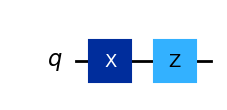

In [5]:
cb = '11'
qcae = qc_alice_encoding(cb)
qcae.draw('mpl')

In [10]:
def qc_dense_coding(cb):
    qc = QuantumCircuit(2, name='DC')
    # compartilha o par emaranhado
    qc.h(0)
    qc.cx(0,1)
    qc.barrier()
    # codificação da Alice
    qcae = qc_alice_encoding(cb)
    qc.append(qcae, [0])
    qc.barrier()
    # decodificação, medida na base de Bell, do Bob
    qc.cx(0,1)
    qc.h(0)
    return qc

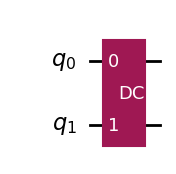

In [14]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
qcdc = qc_dense_coding('01')
qc.append(qcdc, [0,1])
qc.draw('mpl')

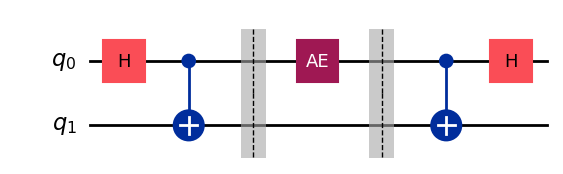

In [15]:
qc.decompose().draw('mpl')

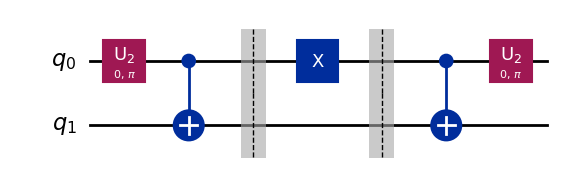

In [16]:
qc.decompose().decompose().draw('mpl')

### Simulação

In [17]:
# só há simulador local agora
from qiskit_aer import AerSimulator
backend = AerSimulator()

In [19]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend=backend)

In [22]:
qc = QuantumCircuit(2,2)
qcdc = qc_dense_coding('00')
qc.append(qcdc, [0,1])
qc.measure([0,1],[0,1])
qc_list = []
qc_list.append(qc.decompose().decompose())
job = sampler.run(qc_list, shots = 2**12 )

In [23]:
counts_sim = job.result()[0].data.c.get_counts()
counts_sim

{'00': 4096}

### Experimento

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="e8d1302bb6027e42bb64c2adface70102ccf7c0eebb5540af70ec91cf079aa513876e4c23d652ab18cb8a59b9fa12efbacde922564e7f2bb8463e1f7b1b2915d")
backend = service.backend(name="ibm_brisbane")

In [26]:
from qiskit import transpile
qc = QuantumCircuit(2,2)
qcdc = qc_dense_coding('00')
qc.append(qcdc, [0,1])
qc.measure([0,1],[0,1])
qc_list = []
qc_list.append(qc.decompose().decompose())
qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

In [27]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

<ipython-input-27-9e853166d33c>:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


In [28]:
job = sampler.run(qc_transpiled_list)
print(job.job_id())

csmxmvb1k2e0008p3b00


In [29]:
job_id = "csmxmvb1k2e0008p3b00"
job = service.job(job_id)
counts_exp = job.result()[0].data.c.get_counts()
counts_exp # é um dicionário do Python

{'01': 280, '00': 3696, '10': 90, '11': 30}

### Gráfico

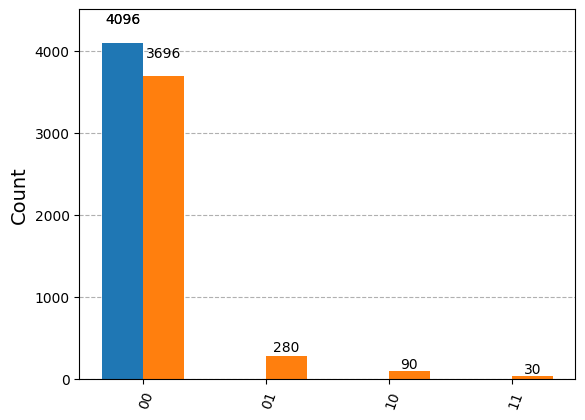

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram([counts_sim,counts_exp])